In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Preprocessing & evaluation
from sklearn.preprocessing import OneHotEncoder, StandardScaler   # encode categoricals; scale numerics
from sklearn.compose import ColumnTransformer                     # apply transforms column-wise
from sklearn.pipeline import Pipeline                             # chain preprocessing + model into one object
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error  # regression metrics

# Linear models (baselines)
from sklearn.linear_model import LinearRegression   # simple OLS baseline, interpretable
from sklearn.linear_model import Ridge              # L2 reg, good when features are correlated
from sklearn.linear_model import Lasso              # L1 reg, feature selection by shrinking some coeffs to 0
from sklearn.linear_model import ElasticNet         # mix of L1+L2, balances feature selection & stability
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# Tree-based models (non-linear, robust)
from sklearn.tree import DecisionTreeRegressor      # single tree, interpretable but prone to overfit
from sklearn.ensemble import RandomForestRegressor  # bagged trees, robust baseline for tabular data
from xgboost import XGBRegressor                    # gradient boosting, usually best performance on tabular data

# Instance-based
from sklearn.neighbors import KNeighborsRegressor   # kNN, uses local averaging, sensitive to scaling & high dimensions

In [2]:
# Load Data
CSV_PATH = "Resaleflatprices.csv"  
df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
df.head(10)

Shape: (216946, 11)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0
5,2017-01,ANG MO KIO,3 ROOM,150,ANG MO KIO AVE 5,01 TO 03,68.0,New Generation,1981,63 years,275000.0
6,2017-01,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,61 years 06 months,280000.0
7,2017-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,04 TO 06,67.0,New Generation,1976,58 years 04 months,285000.0
8,2017-01,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,61 years 06 months,285000.0
9,2017-01,ANG MO KIO,3 ROOM,571,ANG MO KIO AVE 3,01 TO 03,67.0,New Generation,1979,61 years 04 months,285000.0


In [3]:
# Dtypes 
print("Dtypes:\n", df.dtypes, "\n")

# Missing values
print("Missing values per column:\n", df.isna().sum(), "\n")

# Unique counts 
print("Unique counts per column:\n", df.nunique())

Dtypes:
 month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object 

Missing values per column:
 month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64 

Unique counts per column:
 month                   105
town                     26
flat_type                 7
block                  2743
street_name             576
storey_range             17
floor_area_sqm          186
flat_model               21
lease_commence_date      57
remaining_lease         692
resale_pr

## Data Cleaning

In [7]:
# Convert the 'month' string (e.g., "2019-03") into a pandas datetime object
df["month"] = pd.to_datetime(df["month"], format="%Y-%m")

# Extract the calendar year (int) from the datetime column 
df["year"] = df["month"].dt.year

# Extract the numeric month (1–12) from the datetime column 
df["month_num"] = df["month"].dt.month

# Check of the new columns created
df[["month", "year", "month_num"]].sample(5, random_state=42)

,month,year,month_num
45669,2019-03-01,2019,3
82571,2020-10-01,2020,10
62664,2019-12-01,2019,12
155290,2023-12-01,2023,12
179062,2024-08-01,2024,8


In [9]:
# Convert storey_range to storey_mid 
import numpy as np

def parse_storey(s):
    """
    Convert a storey range like '10 TO 12' into its numeric midpoint (e.g., 11.0).
    """
    try:
        low, high = s.split(" TO ")           # Split by the literal string " TO "
        low_i, high_i = int(low), int(high)   # Convert the two tokens to integers
        return (low_i + high_i) / 2.0         # Midpoint of the range
    except Exception:
        return np.nan                          # Fallback for any bad/missing values

# Apply the parser to the whole column to create a numeric feature.
df["storey_mid"] = df["storey_range"].apply(parse_storey)

# Check
df[["storey_range", "storey_mid"]].sample(5, random_state=42)

,storey_range,storey_mid
45669,01 TO 03,2.0
82571,01 TO 03,2.0
62664,07 TO 09,8.0
155290,01 TO 03,2.0
179062,01 TO 03,2.0


In [12]:
# Convert remaining_lease to remaining_lease_years 
def parse_remaining_lease(s):
    """
    Parse text like '61 years 04 months' or '77 years' and return decimal years.
    Examples:
      '61 years 04 months' -> 61 + 4/12 = 61.333...
      '77 years'           -> 77.0
    """
    try:
        s = s.strip()                          # Remove surrounding whitespace
        parts = s.split()                      # Tokenize by whitespace
        years = int(parts[0])                  # First token should be the integer years

        months = 0
        # Look for a numeric token that represents months 
        # Typical positions: parts[2] is the month number when present.
        # Cannot use months = int(parts[2]) because NaN if remaining_lease have no months
        for tok in parts[1:]:
            # If we find a purely digit token after 'years', treat it as months
            if tok.isdigit():
                months = int(tok)
                break

        return years + months / 12.0
    except Exception:
        return np.nan

# Apply parser to the text column to produce a numeric feature in years.
df["remaining_lease_years"] = df["remaining_lease"].apply(parse_remaining_lease)

# Check
df[["remaining_lease", "remaining_lease_years"]].sample(5, random_state=42)

,remaining_lease,remaining_lease_years
45669,64 years,64.000000
82571,77 years 10 months,77.833333
62664,50 years 07 months,50.583333
155290,70 years 10 months,70.833333
179062,60 years 11 months,60.916667


In [15]:
# Flat_age (from remaining lease) 
# Every HDB flat starts with a 99-year lease.

df["flat_age"] = 99 - df["remaining_lease_years"]

# Check: compare remaining lease vs calculated flat_age
df[["remaining_lease", "remaining_lease_years", "flat_age"]].sample(5, random_state=42)


,remaining_lease,remaining_lease_years,flat_age
45669,64 years,64.000000,35.000000
82571,77 years 10 months,77.833333,21.166667
62664,50 years 07 months,50.583333,48.416667
155290,70 years 10 months,70.833333,28.166667
179062,60 years 11 months,60.916667,38.083333


## Feature Selection + Train/Val/Test Split

In [21]:
FEATURES = [
    "town", "flat_type", "flat_model",             # categoricals
    "floor_area_sqm", "storey_mid", "flat_age"     # numeric
]
TARGET = "resale_price"


In [23]:
# Split dataset by year 
train_df = df[df["year"].between(2017, 2023)]
val_df   = df[df["year"] == 2024]
test_df  = df[df["year"] == 2025]

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)

# Separate predictors and target
X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_val,   y_val   = val_df[FEATURES], val_df[TARGET]
X_test,  y_test  = test_df[FEATURES], test_df[TARGET]


Train: (169150, 16) Val: (27832, 16) Test: (19964, 16)


## Baseline: Linear Regression

Linear Regression is the most basic regression algorithm. It assumes that the target variable can be expressed as a weighted sum of the input features plus an intercept. In other words, it fits a straight line (or hyperplane in higher dimensions) that minimizes the squared differences between predicted and actual values. The model is simple, efficient, and highly interpretable, but it is limited because it can only capture linear relationships between variables.

### LinearRegression()
- **fit_intercept**: Whether to calculate the intercept (default=True). If False, the regression line is forced through the origin.  
- **n_jobs**: Number of CPU cores to use for computation. `-1` uses all available cores.  
- **positive**: If True, forces all regression coefficients to be positive. This can be useful when negative coefficients don’t make sense for the problem domain.  

In [28]:
# Preprocessing + model pipeline 
# Separate categorical and numeric features
categorical = ["town", "flat_type", "flat_model"]
numeric     = ["floor_area_sqm", "storey_mid", "flat_age"]

# ColumnTransformer lets us apply one-hot encoding only to categoricals and pass numeric features through unchanged.
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numeric)
    ]
)

# Build a pipeline: preprocessing + linear regression
linreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", LinearRegression())
])

# Train baseline model 
linreg_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [29]:
# Define function for evaluating models  
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """Compute metrics and return them as a dictionary (no printing)."""
    # Train predictions
    y_train_pred = model.predict(X_train)
    mae_train  = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train   = r2_score(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

    # Validation predictions
    y_val_pred = model.predict(X_val)
    mae_val  = mean_absolute_error(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    r2_val   = r2_score(y_val, y_val_pred)
    mape_val = mean_absolute_percentage_error(y_val, y_val_pred)

    return {
        "model": model_name,
        "train": {"MAE": mae_train, "RMSE": rmse_train, "R2": r2_train, "MAPE": mape_train},
        "val":   {"MAE": mae_val,   "RMSE": rmse_val,   "R2": r2_val,   "MAPE": mape_val},
        "y_val_pred" : y_val_pred # For scatterplot
    }

# Define function for printing results
def print_results(results):
    """Print the results dictionary returned by evaluate_model()."""
    print(f"{results['model']} Evaluation:")
    print("\nTrain Results:")
    print(f"  MAE : {results['train']['MAE']:,.0f}")
    print(f"  RMSE: {results['train']['RMSE']:,.0f}")
    print(f"  R²  : {results['train']['R2']:.3f}")
    print(f"  MAPE: {results['train']['MAPE'] * 100:.2f}%")

    print("\nValidation Results:")
    print(f"  MAE : {results['val']['MAE']:,.0f}")
    print(f"  RMSE: {results['val']['RMSE']:,.0f}")
    print(f"  R²  : {results['val']['R2']:.3f}")
    print(f"  MAPE: {results['val']['MAPE'] * 100:.2f}%")

# Define function for plotting scatter plot
def plot_scatterplot(y_true, y_pred, title):
    plt.figure(figsize=(7,7))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], "r--")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(title)
    
    # format y-axis as full numbers
    plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    plt.gca().xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    plt.show()

In [32]:
# Run evaluation
linreg_results = evaluate_model(linreg_model, X_train, y_train, X_val, y_val, "Linear Regression")

# Print results
print_results(linreg_results)

Linear Regression Evaluation:

Train Results:
  MAE : 67,508
  RMSE: 83,537
  R²  : 0.758
  MAPE: 14.61%

Validation Results:
  MAE : 141,807
  RMSE: 160,297
  R²  : 0.278
  MAPE: 22.92%


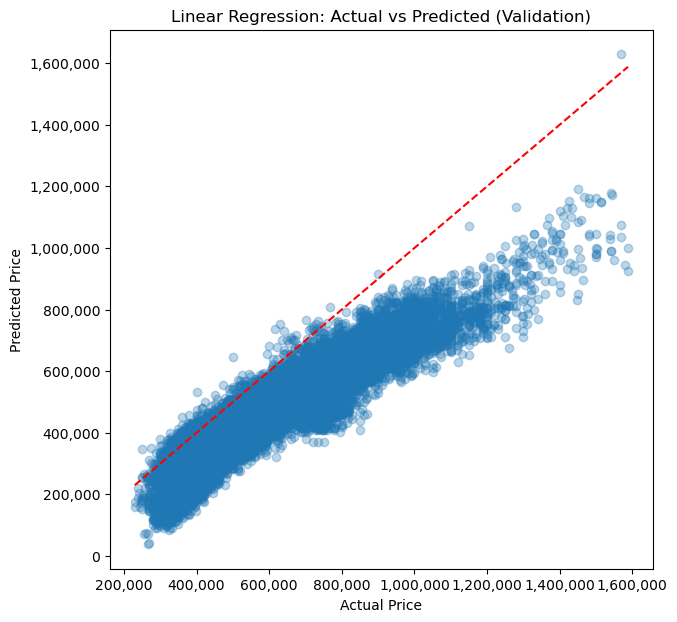

In [34]:
# Scatterplot
plot_scatterplot(
    y_val, 
    linreg_results["y_val_pred"],
    title="Linear Regression: Actual vs Predicted (Validation)"
)

### Metrics Explained
- **Mean Absolute Error (MAE):** This is the average of the absolute differences between predicted and actual values. It tells us, on average, how many dollars off the model’s predictions are. A lower MAE means more accurate predictions in real terms.  
- **Root Mean Squared Error (RMSE):** This is the square root of the average squared differences between predicted and actual values. RMSE penalizes large errors more than MAE, so it highlights cases where the model is making very poor predictions.  
- **R² (Coefficient of Determination):** This measures how much of the variance in the target variable (resale prices) is explained by the model. A value of 1.0 means perfect prediction, 0 means the model is no better than predicting the average, and negative values mean the model is worse than that.

### Linear Regression Evaluation  

| Metric | Train Results | Validation Results |
|--------|---------------|---------------------|
| **MAE**  | \$67,508   | \$141,805   |
| **RMSE** | \$83,537   | \$160,294   |
| **R²**   | 0.758      | 0.278       |
| **MAPE** | 14.61%     | 22.92%      |

The training results look fairly strong: an R² of **0.758** means the model explains about 76% of the variation in resale prices within the training data, and the errors (MAE ≈ \$67k, MAPE ≈ 15%) are reasonably low relative to HDB flat prices.  

However, the validation results show a dramatic drop in performance. The R² falls to **0.278**, meaning the model explains only about 28% of the variance in unseen data. The errors also more than double (MAE jumps from 67k to 142k, MAPE rises from ~15% to ~23%). This gap indicates clear **overfitting**: the model is fitting patterns too closely in the training data but fails to generalize.  

In practical terms, while the model looks “okay” on past data, it would give unreliable and inconsistent predictions for new resale flats. This suggests that plain Linear Regression is too simplistic for this dataset, which likely requires either **regularization** (Ridge/Lasso/ElasticNet) or a more flexible, nonlinear algorithm (tree-based models, boosting, etc.) to capture the complex pricing dynamics of Singapore’s resale market.  


## Ridge Regression (L2 regularization) 

Ridge Regression is a variant of Linear Regression that adds an L2 penalty term to the loss function. This penalty shrinks large coefficients, which can help when features are correlated with each other. The aim is to improve stability and prevent the model from relying too heavily on any one feature. Ridge is particularly useful when multicollinearity is present.

### Ridge()
- **alpha**: Regularization strength (default=1.0). Higher values shrink coefficients more strongly.  
- **fit_intercept**: Whether to calculate the intercept (default=True).  
- **solver**: Algorithm to use in optimization ("auto", "saga", "lsqr", etc.).  

In [40]:
# Ridge Regression (L2 regularization) 
# Define model pipeline
ridge_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", RidgeCV(
        alphas=[0.01, 0.1, 1, 10, 100],  # candidate alphas
        cv=5                             # 5-fold cross-validation
    ))  
])

# Train
ridge_model.fit(X_train, y_train)

print("Best alpha selected by CV:", ridge_model.named_steps["regressor"].alpha_)

Best alpha selected by CV: 1.0


In [42]:
# Evaluate
ridge_results = evaluate_model(
    ridge_model, X_train, y_train, X_val, y_val, model_name="Ridge Regression"
)

print_results(ridge_results)

Ridge Regression Evaluation:

Train Results:
  MAE : 67,505
  RMSE: 83,538
  R²  : 0.758
  MAPE: 14.61%

Validation Results:
  MAE : 141,793
  RMSE: 160,291
  R²  : 0.278
  MAPE: 22.92%


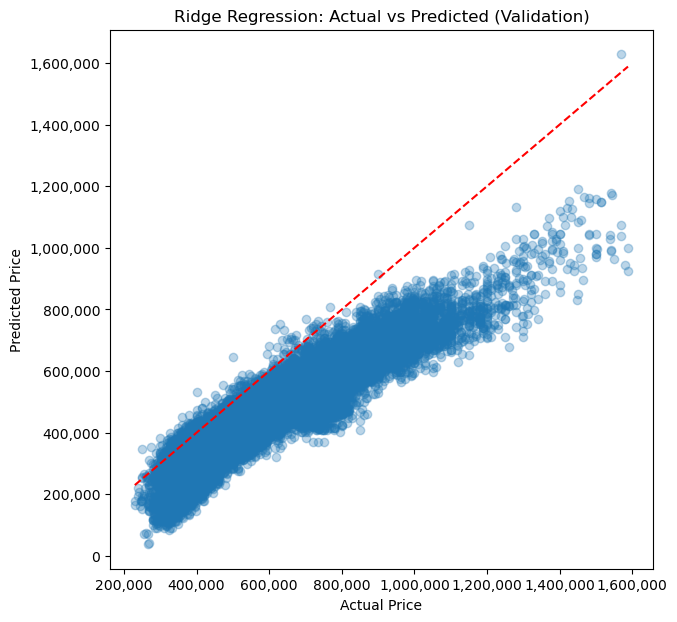

In [44]:
# Scatterplot 
plot_scatterplot(
    y_val,
    ridge_results["y_val_pred"],
    title="Ridge Regression: Actual vs Predicted (Validation)"
)

### Ridge Regression Evaluation  

| Metric | Train Results | Validation Results |
|--------|---------------|---------------------|
| **MAE**  | \$67,505   | \$141,793   |
| **RMSE** | \$83,538   | \$160,291   |
| **R²**   | 0.758      | 0.278       |
| **MAPE** | 14.61%     | 22.92%      |

The training results look fairly strong: an R² of **0.758** indicates that Ridge Regression explains about 76% of the variation in resale prices within the training data, with relatively low errors (MAE ≈ \$67k, MAPE ≈ 15%).  

However, the validation results are almost identical to those of plain Linear Regression. The R² remains at **0.278**, and the errors (MAE ≈ \$142k, MAPE ≈ 23%) show no meaningful improvement. This suggests that multicollinearity is not a major issue in the dataset, and the addition of L2 regularization provides no practical benefit over the baseline model.  

In practical terms, Ridge Regression fails to address the overfitting observed in Linear Regression. This points to the need for either **Lasso/ElasticNet** (to handle feature selection) or more flexible, nonlinear models (tree-based ensembles, boosting, etc.) that can better capture the complex drivers of resale flat prices in Singapore.  


## Lasso Regression (L1 regularization) 

Lasso Regression is another variant of Linear Regression, but instead of an L2 penalty it uses an L1 penalty. The effect of this is that some coefficients can be shrunk exactly to zero, which effectively removes those features from the model. This makes Lasso useful for feature selection in datasets with many irrelevant predictors.

### Lasso()
- **alpha**: Regularization strength (default=1.0). Controls sparsity by forcing some coefficients to zero.  
- **fit_intercept**: Whether to calculate the intercept (default=True).  
- **max_iter**: Maximum number of iterations for optimization (default=1000). May need to be increased if the model does not converge. 

In [50]:
# Lasso Regression (L1 regularization) 
lasso_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", LassoCV(
        alphas=[0.001, 0.01, 0.1, 1, 10, 100],  # candidate alphas
        cv=5,
        max_iter=10000,
        random_state=42,
        tol=1e-2
    ))
])

# Train
lasso_model.fit(X_train, y_train)

print("Best alpha selected by CV:", lasso_model.named_steps["regressor"].alpha_)

Best alpha selected by CV: 0.1


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.350e+14, tolerance: 4.880e+13
  model = cd_fast.sparse_enet_coordinate_descent(


In [51]:
# Evaluate
lasso_results = evaluate_model(
    lasso_model, X_train, y_train, X_val, y_val, model_name="Lasso Regression"
)
print_results(lasso_results)

Lasso Regression Evaluation:

Train Results:
  MAE : 67,508
  RMSE: 83,537
  R²  : 0.758
  MAPE: 14.61%

Validation Results:
  MAE : 141,808
  RMSE: 160,298
  R²  : 0.278
  MAPE: 22.92%


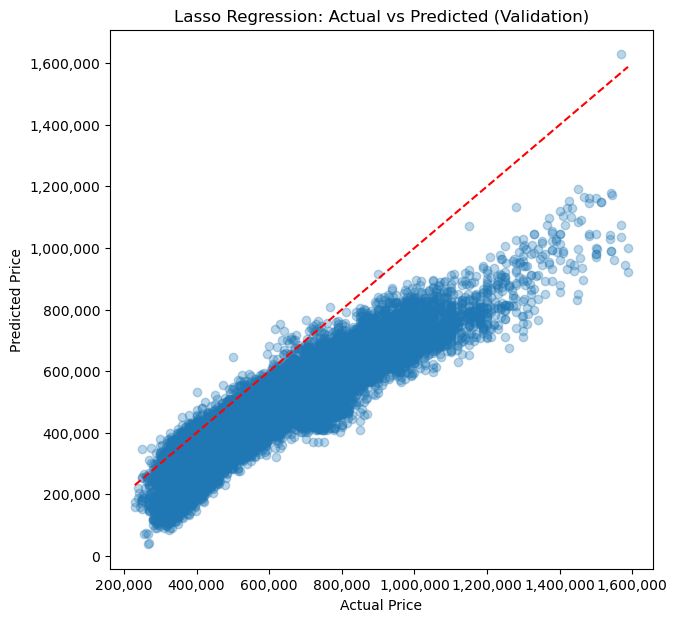

In [52]:
# Scatterplot 
plot_scatterplot(
    y_val,
    lasso_results["y_val_pred"],
    title="Lasso Regression: Actual vs Predicted (Validation)"
)

### Lasso Regression Evaluation  

| Metric | Train Results | Validation Results |
|--------|---------------|---------------------|
| **MAE**  | \$67,508   | \$141,808   |
| **RMSE** | \$83,537   | \$160,298   |
| **R²**   | 0.758      | 0.278       |
| **MAPE** | 14.61%     | 22.92%      |

The training results show an R² of **0.758**, indicating that Lasso explains about 76% of the variation in resale prices within the training data, with relatively low errors (MAE ≈ $68k, MAPE ≈ 15%).  

On the validation dataset, however, the results (R² = **0.278**, MAE ≈ $142k, MAPE ≈ 23%) are almost identical to both Linear and Ridge Regression. This shows that L1 regularization did not meaningfully improve model performance or reduce overfitting.  

In practical terms, Lasso provides no advantage for this dataset. The lack of improvement suggests that redundant or irrelevant features are not the main issue, and the real limitation lies in the linear model’s inability to capture the complex, nonlinear drivers of resale flat prices in Singapore. More flexible approaches such as **ElasticNet** (L1+L2) or **tree-based models** (Random Forests, Gradient Boosting, XGBoost) are likely needed to achieve stronger generalization.  


## Elastic Net (L1 + L2 regularization) 

Elastic Net combines both the L1 penalty from Lasso and the L2 penalty from Ridge, aiming to balance coefficient shrinkage with feature selection. It is particularly useful when features are both correlated and redundant, as it provides a compromise between the strengths of Ridge and Lasso.

### ElasticNet()
- **alpha**: Overall regularization strength (default=1.0).  
- **l1_ratio**: Balance between L1 (Lasso) and L2 (Ridge) penalties. 0 = pure Ridge, 1 = pure Lasso.  
- **fit_intercept**: Whether to calculate the intercept (default=True).  
- **max_iter**: Maximum number of iterations for optimization (default=1000).  

In [60]:
# Elastic Net (L1 + L2 regularization) 
elasticnet_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", ElasticNetCV(
        alphas=[0.1, 1, 10, 100],  # candidate alphas
        l1_ratio=[0.3, 0.5, 0.7],     # mix between L1 and L2
        cv=5,
        max_iter=10000,
        random_state=42
    ))
])

# Train
elasticnet_model.fit(X_train, y_train)

print("Best alpha selected by CV:", elasticnet_model.named_steps["regressor"].alpha_)
print("Best l1_ratio selected by CV:", elasticnet_model.named_steps["regressor"].l1_ratio_)

Best alpha selected by CV: 0.1
Best l1_ratio selected by CV: 0.7


In [62]:
# Evaluate
elasticnet_results = evaluate_model(
    elasticnet_model, X_train, y_train, X_val, y_val, model_name="ElasticNet Regression"
)
print_results(elasticnet_results)

ElasticNet Regression Evaluation:

Train Results:
  MAE : 74,436
  RMSE: 95,219
  R²  : 0.686
  MAPE: 15.66%

Validation Results:
  MAE : 137,699
  RMSE: 165,291
  R²  : 0.232
  MAPE: 21.28%


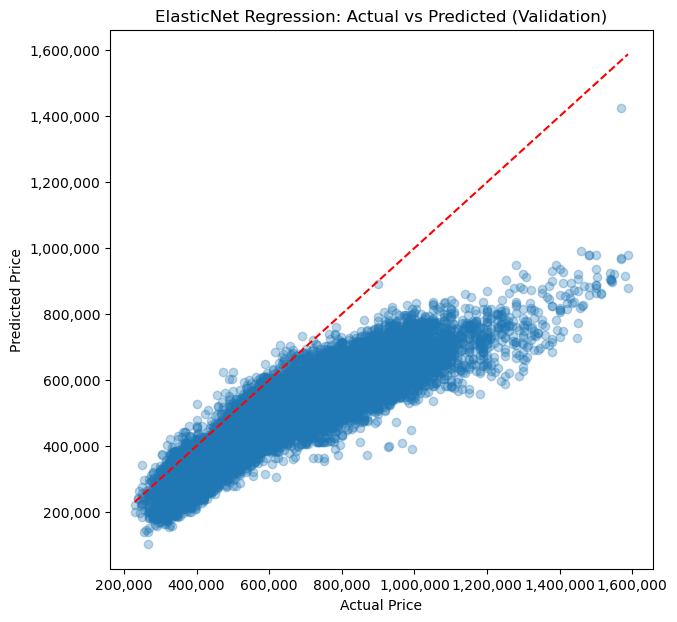

In [64]:
# Scatterplot 
plot_scatterplot(
    y_val,
    elasticnet_results["y_val_pred"],
    title="ElasticNet Regression: Actual vs Predicted (Validation)"
)

### ElasticNet Regression Evaluation  

| Metric | Train Results | Validation Results |
|--------|---------------|---------------------|
| **MAE**  | \$74,436   | \$137,699   |
| **RMSE** | \$95,219   | \$165,291   |
| **R²**   | 0.686      | 0.232       |
| **MAPE** | 15.66%     | 21.28%      |

The training results show an R² of **0.686**, lower than both Ridge and Lasso, with higher errors (MAE ≈ $74k, MAPE ≈ 16%). This indicates that ElasticNet applies stronger shrinkage, reducing model complexity and explanatory power on the training set.  

On the validation dataset, ElasticNet achieves an R² of **0.232** with MAE ≈ $138k and MAPE ≈ 21%. Compared to Linear, Ridge, and Lasso, this represents **slightly worse generalization**. The combination of L1 and L2 penalties did not provide any benefit here and in fact reduced accuracy due to excessive regularization.  

In practical terms, ElasticNet further confirms that the core limitation is not multicollinearity or redundant predictors, but the **linear form of the model itself**. To improve predictive power, more flexible nonlinear approaches such as **tree-based ensembles (Random Forests, Gradient Boosting, XGBoost, LightGBM)** or **neural networks** should be considered to better capture complex housing price dynamics.  


## Decision Tree Regressor

The Decision Tree Regressor is a nonlinear model that predicts outcomes by recursively splitting the dataset into smaller and smaller regions. At each node, the algorithm chooses the feature and threshold that best reduces prediction error, and each terminal leaf node predicts the average target value of the samples it contains. Decision Trees can naturally capture nonlinear relationships and interactions between features, which makes them much more flexible than linear models. They are also easy to interpret, as the splits can be visualized as if/else rules. However, they are prone to overfitting if allowed to grow too deep, so hyperparameters such as maximum depth and minimum samples per split are used to control complexity.

### DecisionTreeRegressor()
- **max_depth**: Maximum depth of the tree. Prevents overfitting.  
- **min_samples_split**: Minimum number of samples needed to split a node.  
- **min_samples_leaf**: Minimum number of samples required at a leaf node.  
- **max_features**: Number of features to consider at each split.  
- **random_state**: Seed for reproducibility.  

In [70]:
# Decision Tree Regressor
dt_model = Pipeline(steps=[
    ("preprocess", preprocess),                         
    ("regressor", DecisionTreeRegressor(
        max_depth=20,                                   
        min_samples_leaf=50,
        min_samples_split=20,
        random_state=42))
])

dt_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [71]:
# Evaluate
dt_results = evaluate_model(
    dt_model, X_train, y_train, X_val, y_val, model_name="Decision Tree Regression"
)
print_results(dt_results)

Decision Tree Regression Evaluation:

Train Results:
  MAE : 49,096
  RMSE: 66,171
  R²  : 0.848
  MAPE: 10.23%

Validation Results:
  MAE : 103,725
  RMSE: 129,706
  R²  : 0.527
  MAPE: 16.08%


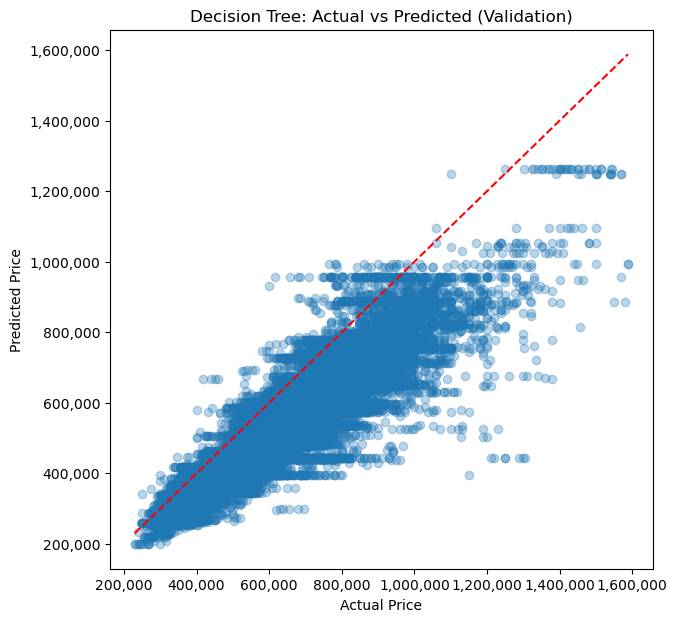

In [72]:
# Scatterplot 
plot_scatterplot(
    y_val,
    dt_results["y_val_pred"],
    title="Decision Tree: Actual vs Predicted (Validation)"
)

### Decision Tree Regression Evaluation  

| Metric | Train Results | Validation Results |
|--------|---------------|---------------------|
| **MAE**  | \$49,096   | \$103,725   |
| **RMSE** | \$66,171   | \$129,706   |
| **R²**   | 0.848      | 0.527       |
| **MAPE** | 10.23%     | 16.08%      |

The training results show a very strong fit, with R² = **0.848** and relatively low errors (MAE ≈ $49k, MAPE ≈ 10%). This means the tree captures much of the variance in the training data.  

On the validation set, performance is significantly better than Linear/Ridge/Lasso/ElasticNet (R² = **0.527**, MAE ≈ $104k, MAPE ≈ 16%). However, the large gap between training and validation R² indicates the model is **still overfitting** — it memorizes training data patterns more than it generalizes.  

In practical terms, while Decision Tree clearly outperforms linear models, relying on a single tree remains risky. The next step is to try **ensemble methods**:  
- **Random Forests** (bagging many trees to reduce variance).  
- **Gradient Boosting / XGBoost / LightGBM** (sequentially improved trees for higher accuracy).  

These approaches usually deliver better generalization and stability than any single tree.  


## Random Forest Regressor

The Random Forest Regressor is an ensemble model that combines the predictions of many individual Decision Trees. Each tree is trained on a random subset of the training data and considers a random subset of features when making splits. This randomness ensures that the trees are diverse, and by averaging their predictions, the Random Forest reduces the variance and instability that a single Decision Tree suffers from. As a result, it is more robust, generalizes better to unseen data, and is less prone to overfitting. Random Forests can naturally model nonlinear relationships and complex feature interactions, making them a powerful upgrade over a single tree.

### RandomForestRegressor()
- **n_estimators**: Number of trees in the forest. More trees = better performance but slower.  
- **max_depth**: Maximum depth of each tree.  
- **min_samples_split**: Minimum number of samples to split a node.  
- **min_samples_leaf**: Minimum number of samples required at a leaf.  
- **max_features**: Number of features to consider at each split.  
- **n_jobs**: Number of CPU cores to use. `-1` = all cores.  
- **random_state**: Seed for reproducibility.  

In [80]:
# Random Forest Regressor
rf_model = Pipeline(steps=[
    ("preprocess", preprocess), 
    ("regressor", RandomForestRegressor(
        n_estimators=500,      
        max_depth=None,         
        min_samples_leaf=10,     
        n_jobs=-1,              
        random_state=42))      
])

rf_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [81]:
# Evaluate
rf_results = evaluate_model(
    rf_model, X_train, y_train, X_val, y_val, model_name="Random Forest Regression"
)
print_results(rf_results)

Random Forest Regression Evaluation:

Train Results:
  MAE : 33,270
  RMSE: 46,286
  R²  : 0.926
  MAPE: 6.95%

Validation Results:
  MAE : 83,877
  RMSE: 110,324
  R²  : 0.658
  MAPE: 12.96%


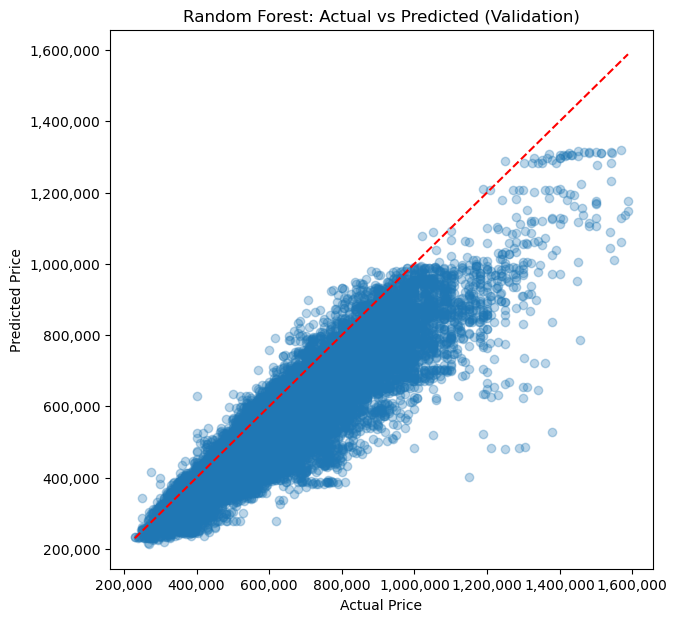

In [82]:
# Scatterplot
plot_scatterplot(
    y_val,
    rf_results["y_val_pred"],
    title="Random Forest: Actual vs Predicted (Validation)"
)

### Random Forest Regression Evaluation  

| Metric | Train Results | Validation Results |
|--------|---------------|---------------------|
| **MAE**  | \$33,270   | \$83,877   |
| **RMSE** | \$46,286   | \$110,324  |
| **R²**   | 0.926      | 0.658     |
| **MAPE** | 6.95%      | 12.96%    |

The training results are very strong, with R² = **0.926** and low errors (MAE ≈ $33k, MAPE ≈ 7%). This indicates that the Random Forest captures most of the variation in resale prices on the training data.  

On the validation dataset, performance remains solid (R² = **0.658**, MAE ≈ $84k, MAPE ≈ 13%), clearly outperforming Linear, Ridge, Lasso, and ElasticNet models, and improving upon a single Decision Tree. However, the gap between training and validation scores suggests some **overfitting** — the model memorizes training data patterns more than it generalizes.  

## XGBoost Regressor

XGBoost (Extreme Gradient Boosting) is an optimized implementation of gradient boosting. Unlike Random Forest, which trains trees independently in parallel, XGBoost builds trees sequentially, where each new tree focuses on correcting the mistakes of the previous ones. This process allows XGBoost to capture complex patterns and interactions very effectively. It also includes many regularization options and efficient handling of large datasets, which have made it one of the most widely used algorithms in machine learning competitions.

### XGBRegressor()
- **n_estimators**: Number of boosting rounds (trees).  
- **learning_rate**: Step size shrinkage. Lower = slower training but better generalization.  
- **max_depth**: Maximum depth of individual trees.  
- **subsample**: Fraction of training samples used per tree (default=1.0).  
- **colsample_bytree**: Fraction of features used per tree.  
- **reg_alpha**: L1 regularization term (default=0).  
- **reg_lambda**: L2 regularization term (default=1).  
- **random_state**: Seed for reproducibility.  

In [90]:
# XGBoost Regressor
xgb_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", XGBRegressor(
        n_estimators=800,        
        learning_rate=0.05,      
        max_depth=30,             
        subsample=0.8,          
        colsample_bytree=0.8,
        min_child_weight=200,
        reg_lambda=1.0,
        reg_alpha=0.1,
        n_jobs=-1,             
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [91]:
# Evaluate
xgb_results = evaluate_model(
    xgb_model, X_train, y_train, X_val, y_val, model_name="XGBoost Regression"
)
print_results(xgb_results)

XGBoost Regression Evaluation:

Train Results:
  MAE : 32,877
  RMSE: 44,941
  R²  : 0.930
  MAPE: 6.94%

Validation Results:
  MAE : 79,273
  RMSE: 104,353
  R²  : 0.694
  MAPE: 12.34%


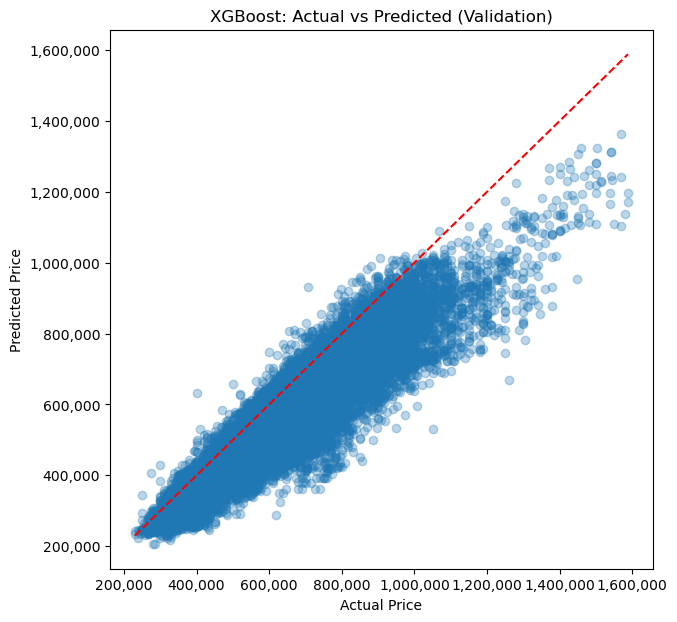

In [92]:
# Scatterplot
plot_scatterplot(
    y_val,
    xgb_results["y_val_pred"],
    title="XGBoost: Actual vs Predicted (Validation)"
)

### XGBoost Regression Evaluation  

| Metric | Train Results | Validation Results |
|--------|---------------|---------------------|
| **MAE**  | \$32,877   | \$79,273   |
| **RMSE** | \$44,941   | \$104,353  |
| **R²**   | 0.930      | 0.694     |
| **MAPE** | 6.94%      | 12.34%    |

The training results are excellent, with R² = **0.930** and very low errors (MAE ≈ $33k, MAPE ≈ 7%), indicating XGBoost captures most of the variance in resale prices.  

On the validation dataset, performance is the strongest among all models tested so far: R² = **0.694**, MAE ≈ $79k, and MAPE ≈ 12%. This represents a clear improvement over Random Forest (R² = 0.658) and a major leap compared to linear models (R² ≈ 0.27).  

In practical terms, XGBoost shows the best generalization ability, balancing high accuracy with reduced overfitting. While the train–validation gap still exists, tuning hyperparameters (e.g., learning rate, max_depth, regularization) could further improve stability. XGBoost is well-suited as the current **best-performing model** for predicting HDB resale prices in this analysis.  


## k-Nearest Neighbors Regressor

The k-Nearest Neighbors (kNN) Regressor is an instance-based algorithm that predicts a value by averaging the target values of the 'k' most similar data points in the training set. Similarity is usually measured by Euclidean distance, although other metrics can be used. The choice of 'k' controls the balance between bias and variance: a small 'k' makes the model more sensitive to local patterns but prone to noise, while a larger 'k' produces smoother predictions but may overlook important details. Weighting neighbors by distance can improve performance by giving more influence to closer data points.

### KNeighborsRegressor()
- **n_neighbors**: Number of neighbors to use (default=5).  
- **weights**: How to weight neighbors ("uniform" or "distance").  
- **metric**: Distance metric to use (default="minkowski", p=2 = Euclidean).  
- **n_jobs**: Number of CPU cores to use. `-1` = all cores.  

In [99]:
# kNN Regressor
knn_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("regressor", KNeighborsRegressor(
        n_neighbors=10,       
        weights="distance",    
        n_jobs=-1              
    ))
])

knn_model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [101]:
# Evaluate
knn_results = evaluate_model(
    knn_model, X_train, y_train, X_val, y_val, model_name="kNN Regression"
)
print_results(knn_results)

kNN Regression Evaluation:

Train Results:
  MAE : 8,986
  RMSE: 21,309
  R²  : 0.984
  MAPE: 2.03%

Validation Results:
  MAE : 84,685
  RMSE: 109,627
  R²  : 0.662
  MAPE: 13.27%


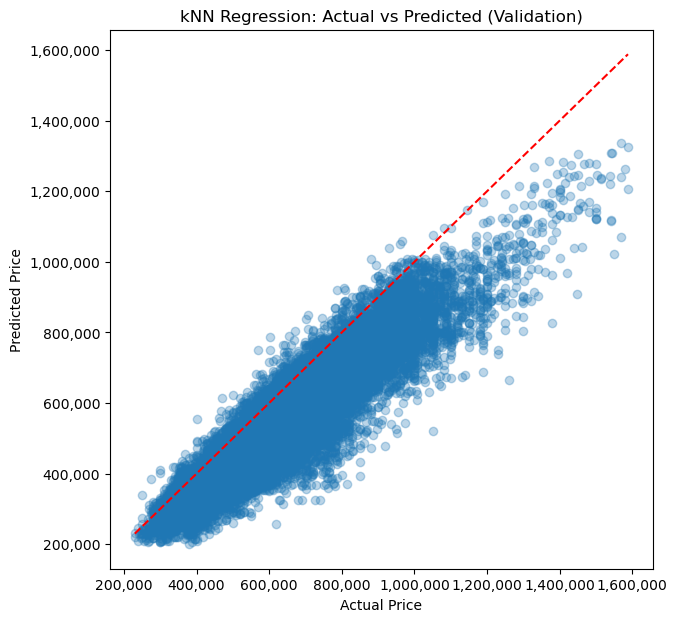

In [103]:
# Scatterplot
plot_scatterplot(
    y_val,
    knn_results["y_val_pred"],
    title="kNN Regression: Actual vs Predicted (Validation)"
)

### kNN Regression Evaluation  

| Metric | Train Results | Validation Results |
|--------|---------------|---------------------|
| **MAE**  | \$8,986    | \$84,685   |
| **RMSE** | \$21,309   | \$109,627  |
| **R²**   | 0.984      | 0.662     |
| **MAPE** | 2.03%      | 13.27%    |

The training results show an almost perfect fit (R² = **0.984**, MAE ≈ $9k, MAPE ≈ 2%), which means kNN is essentially memorizing the training data.  

On the validation dataset, performance drops notably (R² = **0.662**, MAE ≈ $85k, MAPE ≈ 13%). While this is still competitive and better than linear models, the large train–validation gap highlights **overfitting**: the model is excellent at remembering training samples but struggles to generalize to unseen data.  

In practical terms, kNN provides solid validation accuracy but suffers from scalability issues (slow predictions on large datasets) and sensitivity to noise and irrelevant features. Tuning the number of neighbors (`n_neighbors`) and distance metric may improve generalization, but for larger datasets, **ensemble tree-based methods (Random Forest, XGBoost, LightGBM)** are usually more robust and efficient.  


In [114]:
def evaluate_on_test(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print(f"\n{model_name} (Test Results):")
    print(f"  MAE : {mae:,.0f}")
    print(f"  RMSE: {rmse:,.0f}")
    print(f"  R²  : {r2:.3f}")
    print(f"  MAPE: {mape*100:.2f}%")

# List all models you trained
models = [
    ("Linear Regression", linreg_model),
    ("Ridge Regression (CV)", ridge_model),
    ("Lasso Regression", lasso_model),
    ("ElasticNet Regression", elasticnet_model),
    ("Decision Tree Regression", dt_model),
    ("Random Forest Regression", rf_model),
    ("XGBoost Regression", xgb_model),
    ("kNN Regression", knn_model),
]

# Print results for each on test set
for name, mdl in models:
    evaluate_on_test(mdl, X_test, y_test, model_name=name)


Linear Regression (Test Results):
  MAE : 181,692
  RMSE: 200,012
  R²  : 0.016
  MAPE: 27.74%

Ridge Regression (CV) (Test Results):
  MAE : 181,666
  RMSE: 200,000
  R²  : 0.016
  MAPE: 27.73%

Lasso Regression (Test Results):
  MAE : 181,694
  RMSE: 200,014
  R²  : 0.016
  MAPE: 27.74%

ElasticNet Regression (Test Results):
  MAE : 177,419
  RMSE: 205,013
  R²  : -0.034
  MAPE: 26.08%

Decision Tree Regression (Test Results):
  MAE : 138,275
  RMSE: 164,654
  R²  : 0.333
  MAPE: 20.42%

Random Forest Regression (Test Results):
  MAE : 121,116
  RMSE: 148,772
  R²  : 0.456
  MAPE: 17.83%

XGBoost Regression (Test Results):
  MAE : 114,140
  RMSE: 140,134
  R²  : 0.517
  MAPE: 16.88%

kNN Regression (Test Results):
  MAE : 123,398
  RMSE: 146,946
  R²  : 0.469
  MAPE: 18.39%


### Test Set Evaluation  

**Linear Models (Linear, Ridge, Lasso, ElasticNet)**  
- Linear, Ridge, and Lasso all performed almost identically on the test set (R² ≈ **0.016**, MAE ≈ $182k, MAPE ≈ 28%).  
- ElasticNet performed slightly differently, but worse overall (R² = **-0.034**), showing that regularization did not improve generalization.  
- These results confirm that **linear models cannot capture the complex patterns** in HDB resale prices.  

**Decision Tree**  
- Improved test performance compared to linear models: R² = **0.333**, MAE ≈ $138k, MAPE ≈ 20%.  
- However, still prone to overfitting — performance lags behind ensemble methods.  

**Random Forest**  
- Stronger results: R² = **0.456**, MAE ≈ $121k, MAPE ≈ 18%.  
- Shows that bagging many trees reduces variance and improves generalization.  

**XGBoost**  
- Best performing model overall: R² = **0.517**, MAE ≈ $114k, MAPE ≈ 17%.  
- Clear improvement over Random Forest and a major leap over linear methods.  
- Confirms that **boosting methods are best suited** for this structured dataset, balancing bias and variance effectively.  

### Key Takeaway  
- **Linear models** (with or without regularization) fail to generalize.  
- **Single Decision Tree** captures nonlinearity but still overfits.  
- **Random Forest** significantly improves generalization.  
- **XGBoost** is the **best model** for this task, achieving the highest R² and lowest errors on the test set.  


## References

[1] Housing & Development Board, 2025, "Resale flat prices based on registration date from Jan-2017 onwards", data.gov.sg. Accessed: September 29, 2025. [Online]. Available: https://data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view